# Selección del clasificador

Alfredo Rodríguez Magdalena ©

In [48]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

## Importación de los datos de entrenamiento

In [35]:
data = mat73.loadmat(r'../datos/experimento3_sep.mat')
labels = scipy.io.loadmat(r'../datos/labelsExperimento3.mat')
Vr14 = scipy.io.loadmat(r'../datos/Vr14.mat')

X = data["X"]
U = data["U"]
N = data["N"]
Y = labels['Y']
Vr14 = Vr14['Vr14']

tm = 5e-3 # Tiempo de muestreo

print(f"Dimensiones de las etiquetas : {Y.shape}")

Dimensiones de las etiquetas : (11953, 1)


In [36]:
scalerX = StandardScaler()
Xnormalizado = scalerX.fit_transform(X)
Unormalizado = U[:,0] / 1000 # Se expresa en m/s

In [37]:
# DS1 -> Todos los datos sin tratar
X1 = np.hstack((Xnormalizado, Unormalizado.reshape(-1,1)))

print(f"Dimensiones de dataset 1 : {X1.T.shape} (características, muestras)")

Dimensiones de dataset 1 : (501, 11953) (características, muestras)


In [38]:
# DS2 -> Datos en la base de Vr14
X2 = Vr14 @ X.T
X2 = np.hstack((X2.T, U[:,0].reshape(-1,1)))

print(f"Dimensiones de la matriz de cambio de base : {Vr14.shape}")
print(f"Dimensiones de dataset 2 : {X2.T.shape} (características, muestras)")

Dimensiones de la matriz de cambio de base : (15, 500)
Dimensiones de dataset 2 : (16, 11953) (características, muestras)


In [39]:
# DS3 -> Datos deducidos a partir de la etapa de extracción de características superficial
X3 = data["F"]
X3 = np.hstack((X3, U[:,0].reshape(-1,1)))

print(f"Dimensiones de dataset 3 : {X3.T.shape} (características, muestras)")

Dimensiones de dataset 3 : (3, 11953) (características, muestras)


In [40]:
datasets = {"DS1" : X1, 
            "DS2" : X2, 
            "DS3" : X3}

## Entrenamiento de modelos

In [41]:
semilla = 92
np.random.seed(semilla) # Semilla para reproducibilidad

In [42]:
# Diccionario con los algoritmos de clasificación
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Gaussian Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "SGD Classifier": SGDClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "ANN": MLPClassifier(max_iter=300),
}

In [43]:
print(np.ravel(Y).shape)

(11953,)


In [46]:
# Función para entrenar y evaluar cada algoritmo en un dataset
results = []
decisionTree = None

for dataset_name, XX in datasets.items():
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(XX, np.ravel(Y), test_size=0.3, random_state=semilla)

    for model_name, model in classifiers.items():
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Medir tiempo de predicción
        start_time = time.time()
        y_pred = model.predict(X_test)
        prediction_time = time.time() - start_time  # Tiempo en segundos

        if model_name == "Decision Tree" and dataset_name == "DS3":
            decisionTree = model

        # Calcular las métricas
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "F1-Score": report["weighted avg"]["f1-score"],
            "Prediction Time [ms]": prediction_time * 10 # Más tarde se multiplica por 100 para obtener ms
        })

# Convertir resultados a un DataFrame
results_df = pd.DataFrame(results)


/opt/anaconda3/envs/SIARM/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/SIARM/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:13:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/SIARM/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of ite

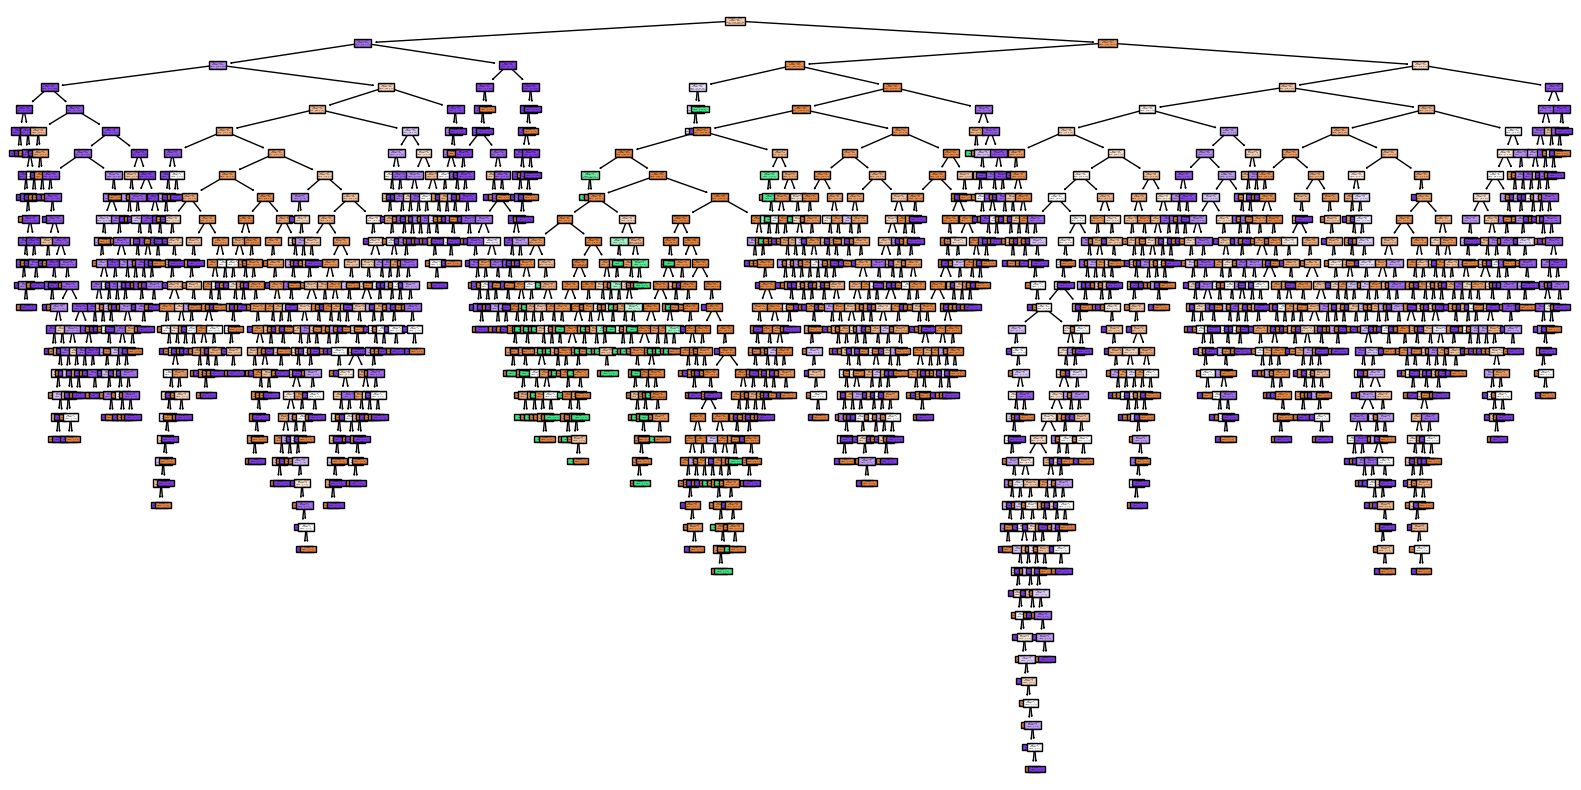

In [50]:
# Visualizar el árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(decisionTree, filled=True, feature_names=["Sección", "Posición", "Velocidad"], class_names=["Flujo Estable", "Burbuja de Aire", "Flujo Inestable"])
plt.show()

In [45]:
numeric_columns = results_df.select_dtypes(include=[np.number]).columns
results_df[numeric_columns] = results_df[numeric_columns].map(lambda x: f"{x*100:.2f}")

results_df.to_csv("resultadosClasificacion.csv", index=False)